In [1]:
# Converting already existing example at https://github.com/rstar900/ML_And_Neural_Nets/blob/main/PyTorch_CIFAR10_Introduction.ipynb
# from PyTorch based nn to Brevitas based Integer Only QNN (3 bit weights, 4 bit ReLU activations, and 8 bits bias)

# Imports (Need torch==1.8.0 and torchvision==0.9.0 to work)
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Import for Brevitas
import brevitas.nn as qnn
from brevitas.quant import Int8Bias as BiasQuant
from brevitas.export import FINNManager

In [2]:
# transform PILImage images from dataset to tensors
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


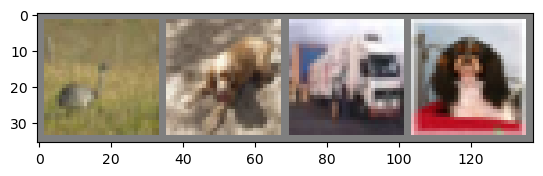

bird  dog   truck dog  


In [3]:
# Just showing image for fun

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Get some random training image
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
# Define a Neural Network (Modified to qnn by converting convolutional layers and fully connected to qnn ones)

class LowPrecisionNet(nn.Module):
    
    def __init__(self):
        super(LowPrecisionNet, self).__init__()
        
        # Input quantization layer
        self.quant_inp = qnn.QuantIdentity(bit_width=4, return_quant_tensor=True)
        
        # 2 convolution layers and Quantized ReLU between each of them
        # 3 input image channel, 6 output channels, 5x5 convolution kernel
        self.conv1 = qnn.QuantConv2d(3, 6, 5, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu1 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        self.conv2 = qnn.QuantConv2d(6, 16, 5, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu2 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        
        # 3 fully connected layers
        # an affine operation: y = Wx + b
        self.fc1 = qnn.QuantLinear(16 * 5 * 5, 120, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu3 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        self.fc2 = qnn.QuantLinear(120, 84, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu4 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        self.fc3 = qnn.QuantLinear(84, 10, bias=False, weight_bit_width=3)
        
        
    def forward(self, x):
        x = self.quant_inp(x)
        x = self.relu1(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.relu2(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.reshape(x.shape[0], -1) # Flatten
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
net = LowPrecisionNet()    


In [5]:
# Define a loss function (Cross-Entropy loss) and an optimizer (Stochastic Gradient Descent with momentum)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [6]:
for epoch in range(10):
    
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0): # enumerate used to put a counter with every data item
        inputs, labels = data
    
        optimizer.zero_grad()
    
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # print stats
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.869
[1,  4000] loss: 1.666
[1,  6000] loss: 1.610
[1,  8000] loss: 1.554
[1, 10000] loss: 1.520
[1, 12000] loss: 1.497
[2,  2000] loss: 1.437
[2,  4000] loss: 1.438
[2,  6000] loss: 1.428
[2,  8000] loss: 1.426
[2, 10000] loss: 1.419
[2, 12000] loss: 1.412
[3,  2000] loss: 1.367
[3,  4000] loss: 1.375
[3,  6000] loss: 1.364
[3,  8000] loss: 1.335
[3, 10000] loss: 1.332
[3, 12000] loss: 1.358
[4,  2000] loss: 1.325
[4,  4000] loss: 1.284
[4,  6000] loss: 1.310
[4,  8000] loss: 1.312
[4, 10000] loss: 1.293
[4, 12000] loss: 1.313
[5,  2000] loss: 1.272
[5,  4000] loss: 1.280
[5,  6000] loss: 1.296
[5,  8000] loss: 1.274
[5, 10000] loss: 1.285
[5, 12000] loss: 1.300
[6,  2000] loss: 1.256
[6,  4000] loss: 1.253
[6,  6000] loss: 1.266
[6,  8000] loss: 1.251
[6, 10000] loss: 1.254
[6, 12000] loss: 1.239
[7,  2000] loss: 1.221
[7,  4000] loss: 1.240
[7,  6000] loss: 1.241
[7,  8000] loss: 1.264
[7, 10000] loss: 1.276
[7, 12000] loss: 1.274
[8,  2000] loss: 1.228
[8,  4000] 

In [7]:
# Save the trained model using pytorch (for verification later with FINN)
torch.save(net.state_dict(), './finn_lenet_state_dict.pth')

# Save using onnx format
FINNManager.export(net, input_shape=(1, 3, 32, 32), export_path='finn_lenet.onnx')

ir_version: 6
producer_name: "pytorch"
producer_version: "1.8"
graph {
  node {
    input: "inp.1"
    input: "15"
    output: "16"
    name: "MultiThreshold_1"
    op_type: "MultiThreshold"
    attribute {
      name: "out_dtype"
      s: "INT4"
      type: STRING
    }
    domain: "finn.custom_op.general"
  }
  node {
    input: "16"
    input: "17"
    output: "18"
    name: "Add_3"
    op_type: "Add"
    domain: ""
  }
  node {
    input: "18"
    input: "19"
    output: "20"
    name: "Mul_5"
    op_type: "Mul"
  }
  node {
    input: "20"
    input: "21"
    output: "23"
    name: "Conv_8"
    op_type: "Conv"
    attribute {
      name: "dilations"
      ints: 1
      ints: 1
      type: INTS
    }
    attribute {
      name: "group"
      i: 1
      type: INT
    }
    attribute {
      name: "kernel_shape"
      ints: 5
      ints: 5
      type: INTS
    }
    attribute {
      name: "pads"
      ints: 0
      ints: 0
      ints: 0
      ints: 0
      type: INTS
    }
    attri

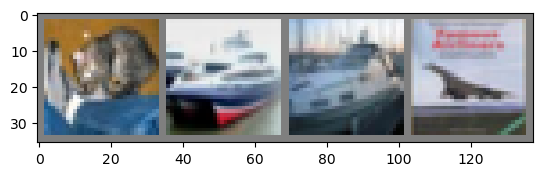

GroundTruth:  cat   ship  ship  plane


In [8]:
# Displaying an image from the test set
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
# Loading saved model not required here

# Check the prediction of the model on the trianing set
outputs = net(images)
_, predicted = torch.max(outputs, 1) # _ is to ignore first thing and 1 is given in max() for the 1st field (0 indexed)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   ship 


In [10]:
# Benchmarking the model over the whole dataset

correct = 0
total = 0

# Not calculating gradients as we are not training
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %') 

Accuracy of the network on the 10000 test images: 53 %


In [11]:
# Calculating classwise accuracy

correct_pred = {classname: 0 for classname in classes} # set each class to 0 in the dictionary
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # count the correct and total predictions
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1 
            
# print the accuracy for each class 
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 50.2 %
Accuracy for class: car   is 64.5 %
Accuracy for class: bird  is 41.7 %
Accuracy for class: cat   is 37.1 %
Accuracy for class: deer  is 48.6 %
Accuracy for class: dog   is 33.3 %
Accuracy for class: frog  is 67.2 %
Accuracy for class: horse is 50.3 %
Accuracy for class: ship  is 75.5 %
Accuracy for class: truck is 63.2 %
